In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import scipy.optimize as spo
plt.style.use('seaborn')

from datetime import datetime as dt

#### Unimportant Warnings

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

#### Custom Files

In [3]:
from data_io import DataIO # Custom IO file

# Input/Output of RGA and Temperature Data

In [4]:
Path = "/home/ael59/project/run_data/2020_11_09/" # data file path

In [5]:
IO = DataIO(Path)

In [6]:
IO.Unzip()

In [7]:
RGA_Data = IO.GetRGAData()

In [8]:
Temp = IO.GetTemperatureData()

In [9]:
#data.to_hdf(p+"10_19_rga_2020.h5", key='data')

In [10]:
RGA_Data.sort_values(by=['Datetime', 'Mass'], inplace=True)
RGA_Data

,Datetime,Mass,Pressure
1244696,2020-11-09 16:59:53,1.0,1.930000e-09
1244697,2020-11-09 16:59:53,1.1,3.310000e-09
1244698,2020-11-09 16:59:53,1.2,6.480000e-08
1244699,2020-11-09 16:59:53,1.3,2.310000e-07
1244700,2020-11-09 16:59:53,1.4,4.750000e-08
...,...,...,...
3372368,2020-11-12 09:05:49,99.6,-1.820000e-10
3372369,2020-11-12 09:05:49,99.7,-1.330000e-10
3372370,2020-11-12 09:05:49,99.8,-8.180000e-11
3372371,2020-11-12 09:05:49,99.9,-4.670000e-11


In [11]:
Temp.sort_values(by='Datetime', inplace=True)
Temp

,Date,Time,CH1,CH2,Datetime
162129,11/10/2020,1:19:00,20.3,20.2,2020-11-10 01:19:00
162130,11/10/2020,1:19:01,20.3,20.3,2020-11-10 01:19:01
162131,11/10/2020,1:19:02,20.3,20.3,2020-11-10 01:19:02
162132,11/10/2020,1:19:03,20.3,20.3,2020-11-10 01:19:03
162133,11/10/2020,1:19:04,20.3,20.3,2020-11-10 01:19:04
...,...,...,...,...,...
49472,11/12/2020,9:34:07,20.4,20.3,2020-11-12 09:34:07
49473,11/12/2020,9:34:08,20.4,20.3,2020-11-12 09:34:08
49474,11/12/2020,9:34:09,20.4,20.3,2020-11-12 09:34:09
49475,11/12/2020,9:34:10,20.4,20.3,2020-11-12 09:34:10


### Times

In [12]:
# Starting RGA Time
rga_start = RGA_Data['Datetime'].sort_values().unique()[0]
rga_start

numpy.datetime64('2020-11-09T16:59:53.000000000')

In [13]:
# Starting temperature time
temps_start = Temp['Datetime'].sort_values().unique()[0]
temps_start

numpy.datetime64('2020-11-10T01:19:00.000000000')

In [14]:
# Find the EARLIEST time to calculate timedeltas from.
if rga_start < temps_start:
    start_datetime = rga_start
else:
    start_datetime = temps_start

In [15]:
start_datetime

numpy.datetime64('2020-11-09T16:59:53.000000000')

In [16]:
temp_times = (Temp['Datetime'] - start_datetime)/np.timedelta64(1, 's')
temp_times

162129     29947.0
162130     29948.0
162131     29949.0
162132     29950.0
162133     29951.0
            ...   
49472     232454.0
49473     232455.0
49474     232456.0
49475     232457.0
49476     232458.0
Name: Datetime, Length: 189801, dtype: float64

In [17]:
# Separate by mass
H2_data = RGA_Data[RGA_Data['Mass'] == 2.0]
H2O_data = RGA_Data[RGA_Data['Mass'] == 18.0]
N2_data = RGA_Data[RGA_Data['Mass'] == 28.0]
O2_data = RGA_Data[RGA_Data['Mass'] == 32.0]
CO2_data = RGA_Data[RGA_Data['Mass'] == 44.0]

In [18]:
rga_times = (RGA_Data['Datetime'].unique() - start_datetime)/np.timedelta64(1, 's')
H2_times = (H2_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')
H2O_times = (H2O_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')
N2_times = (N2_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')
O2_times = (O2_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')
CO2_times = (CO2_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')

In [19]:
CO2_times

1245126         0.0
3224153        41.0
2963520        83.0
748635        124.0
1839726       166.0
             ...   
1775311    230590.0
2526489    230632.0
4378668    230673.0
419623     230715.0
3371812    230756.0
Name: Datetime, Length: 5568, dtype: float64

### Temperature Interpolation

In [20]:
pd.to_numeric(Temp['CH1'])

162129    20.3
162130    20.3
162131    20.3
162132    20.3
162133    20.3
          ... 
49472     20.4
49473     20.4
49474     20.4
49475     20.4
49476     20.4
Name: CH1, Length: 189801, dtype: float64

In [21]:
CO2_ch1_lerp = np.interp(CO2_times, temp_times, pd.to_numeric(Temp['CH1']))
CO2_ch2_lerp = np.interp(CO2_times, temp_times, pd.to_numeric(Temp['CH2']))

### Final Data Frames

In [22]:
## Build CO2 final data frame
CO2_final_data = pd.DataFrame(data=CO2_times)
CO2_final_data.columns = ['Exp_Time']
# Microtorr now
CO2_final_data['CO2_Pressure'] = CO2_data['Pressure']
# Celsius to Kelvin
CO2_final_data['ch1_lerp'] = CO2_ch1_lerp + 273.2
CO2_final_data['ch2_lerp'] = CO2_ch2_lerp + 273.2
CO2_final_data['temp_est'] = (CO2_final_data['ch1_lerp'] + CO2_final_data['ch2_lerp'])/2.0
CO2_final_data

,Exp_Time,CO2_Pressure,ch1_lerp,ch2_lerp,temp_est
1245126,0.0,7.660000e-07,293.5,293.4,293.45
3224153,41.0,7.640000e-07,293.5,293.4,293.45
2963520,83.0,7.720000e-07,293.5,293.4,293.45
748635,124.0,7.780000e-07,293.5,293.4,293.45
1839726,166.0,7.900000e-07,293.5,293.4,293.45
...,...,...,...,...,...
1775311,230590.0,1.390000e-08,293.6,293.5,293.55
2526489,230632.0,1.410000e-08,293.6,293.5,293.55
4378668,230673.0,1.420000e-08,293.6,293.5,293.55
419623,230715.0,1.400000e-08,293.6,293.5,293.55


In [23]:
CO2_final_data.sort_values(by='Exp_Time', inplace=True)
CO2_final_data

,Exp_Time,CO2_Pressure,ch1_lerp,ch2_lerp,temp_est
1245126,0.0,7.660000e-07,293.5,293.4,293.45
3224153,41.0,7.640000e-07,293.5,293.4,293.45
2963520,83.0,7.720000e-07,293.5,293.4,293.45
748635,124.0,7.780000e-07,293.5,293.4,293.45
1839726,166.0,7.900000e-07,293.5,293.4,293.45
...,...,...,...,...,...
1775311,230590.0,1.390000e-08,293.6,293.5,293.55
2526489,230632.0,1.410000e-08,293.6,293.5,293.55
4378668,230673.0,1.420000e-08,293.6,293.5,293.55
419623,230715.0,1.400000e-08,293.6,293.5,293.55


### Curve Fitting
$$p(t,T) = A\cdot \exp\left(-\frac{b}{T}\right)\cdot\exp\left(-c\cdot t\cdot \exp\left(-\frac{b}{T}\right)\right)$$

In [24]:
def pressure_fit(tT, A, b, c):
    # (k,M) array if there are k predictors
    factor = np.exp(-1.0*b/tT[1])
    return A * factor * np.exp(-1.0*c*tT[0]*factor)

In [25]:
#O2_jump1 = O2_final_data[O2_final_data['Datetime'].between(51000, 65000)]

In [26]:
#O2_Tdata = O2_jump1[['Datetime', 'temp_est']].T.to_numpy()
#O2_Tdata.shape

In [27]:
# Initial guess of uncertainties
#O2_sigma = np.empty(O2_Tdata.shape[1]); O2_sigma.fill(1e-9)
#O2_sigma.shape

In [28]:
#popt, pcov = spo.curve_fit(pressure_fit, O2_Tdata, O2_jump1['O2_Pressure'], p0=[50, 5800, 980], bounds=([-np.inf, -np.inf, 0],np.inf), maxfev=8000)

In [29]:
#popt

In [30]:
#pcov

In [31]:
#fit_vals = pressure_fit(O2_Tdata, popt[0], popt[1], popt[2])
#fit_vals

In [32]:
CO2_jump4 = CO2_final_data[CO2_final_data['Exp_Time'].between(111000, 150000)]
CO2_jump4

,Exp_Time,CO2_Pressure,ch1_lerp,ch2_lerp,temp_est
4650202,111006.0,1.040000e-07,321.3,328.7,325.00
5202189,111048.0,1.040000e-07,321.4,328.8,325.10
475119,111089.0,1.040000e-07,321.6,328.9,325.25
5149666,111131.0,1.060000e-07,321.7,329.0,325.35
5011917,111172.0,1.050000e-07,321.8,329.1,325.45
...,...,...,...,...,...
2635499,149804.0,7.210000e-08,328.3,331.0,329.65
2860456,149845.0,7.220000e-08,328.4,331.0,329.70
4538219,149887.0,7.260000e-08,328.3,331.0,329.65
1340262,149928.0,7.210000e-08,328.3,331.0,329.65


In [33]:
CO2_4T_start = CO2_jump4['Exp_Time'].unique()[0]
CO2_4T_start

111006.0

In [34]:
CO2_jump4['Jump_Time'] = CO2_jump4['Exp_Time'] - CO2_4T_start
CO2_jump4

/gpfs/loomis/project/david_moore/ael59/conda_envs/nexo/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Exp_Time,CO2_Pressure,ch1_lerp,ch2_lerp,temp_est,Jump_Time
4650202,111006.0,1.040000e-07,321.3,328.7,325.00,0.0
5202189,111048.0,1.040000e-07,321.4,328.8,325.10,42.0
475119,111089.0,1.040000e-07,321.6,328.9,325.25,83.0
5149666,111131.0,1.060000e-07,321.7,329.0,325.35,125.0
5011917,111172.0,1.050000e-07,321.8,329.1,325.45,166.0
...,...,...,...,...,...,...
2635499,149804.0,7.210000e-08,328.3,331.0,329.65,38798.0
2860456,149845.0,7.220000e-08,328.4,331.0,329.70,38839.0
4538219,149887.0,7.260000e-08,328.3,331.0,329.65,38881.0
1340262,149928.0,7.210000e-08,328.3,331.0,329.65,38922.0


In [35]:
CO2_4T = CO2_jump4[['Jump_Time', 'temp_est']].T.to_numpy()

In [36]:
fit_jump = CO2_jump4['CO2_Pressure'].to_numpy()

In [37]:
popt, pcov = spo.curve_fit(pressure_fit, CO2_4T, fit_jump, p0=[5.65, 5800, 658], maxfev=100000)

In [38]:
popt

array([   6.10134371, 5824.92520071,  725.40372232])

In [39]:
pcov

array([[9.75726044e-01, 5.25570651e+01, 1.16571753e+02],
       [5.25570651e+01, 2.83099703e+03, 6.27895658e+03],
       [1.16571753e+02, 6.27895658e+03, 1.39281144e+04]])

In [40]:
CO2_4_fits = pressure_fit(CO2_4T, popt[0], popt[1], popt[2])

### Plotting

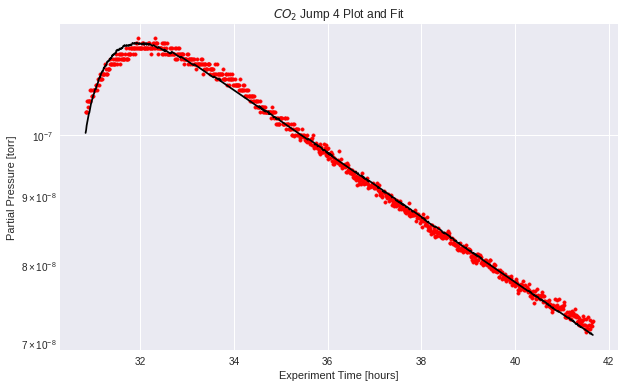

In [41]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(CO2_jump4['Exp_Time']/3600, CO2_jump4['CO2_Pressure'], marker='.', color='red')
ax.plot(CO2_jump4['Exp_Time']/3600, CO2_4_fits, color='black')
ax.set_ylabel('Partial Pressure [torr]')
ax.set_xlabel('Experiment Time [hours]')
ax.set_title('$CO_2$ Jump 4 Plot and Fit')
ax.set_yscale('log')
fig.savefig('images/co2_4_fit_2020_11_09.png', dpi=144)

plt.show()

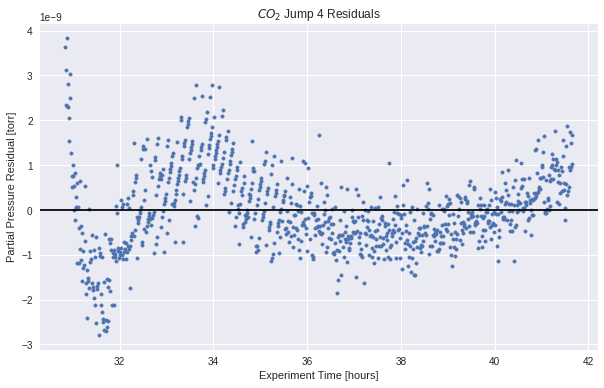

In [42]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(CO2_jump4['Exp_Time']/3600, CO2_jump4['CO2_Pressure'] - CO2_4_fits, marker='.')
ax.set_ylabel('Partial Pressure Residual [torr]')
ax.set_xlabel('Experiment Time [hours]')
ax.axhline(color='k')
ax.set_title('$CO_2$ Jump 4 Residuals')
#ax.set_yscale('log')
fig.savefig('images/co2_4_resid_2020_11_09.png', dpi=144)

plt.show()

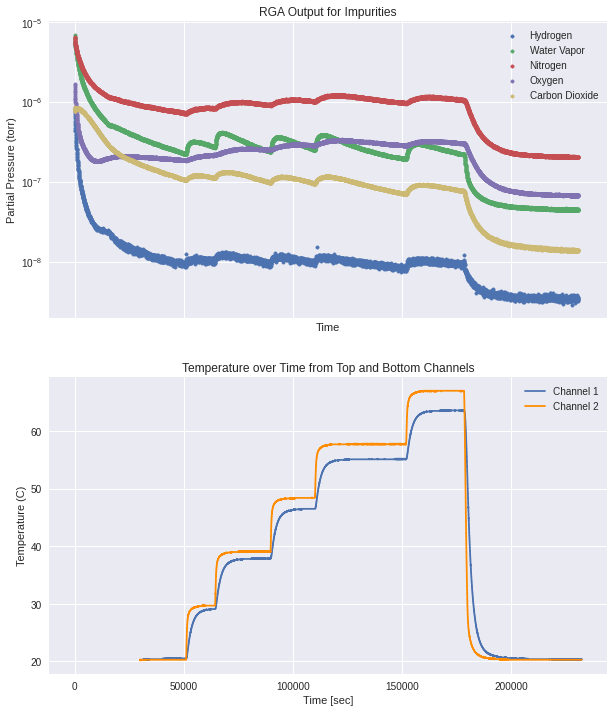

In [43]:
fig, ax = plt.subplots(figsize=(10,12),  nrows = 2, sharex=True)
ax[0].scatter(H2_times, H2_data['Pressure'], marker='.', label='Hydrogen')
ax[0].scatter(H2O_times, H2O_data['Pressure'], marker='.', label='Water Vapor')
ax[0].scatter(N2_times, N2_data['Pressure'], marker='.', label='Nitrogen')
ax[0].scatter(O2_times, O2_data['Pressure'], marker='.', label='Oxygen')
ax[0].scatter(CO2_times, CO2_data['Pressure'], marker='.', label='Carbon Dioxide')
ax[0].set_title('RGA Output for Impurities')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Partial Pressure (torr)')
ax[0].legend()
ax[0].set_yscale('log')

ax[1].plot(temp_times, pd.to_numeric(Temp['CH1']), label='Channel 1')
ax[1].plot(temp_times, pd.to_numeric(Temp['CH2']), label='Channel 2', color='darkorange')
ax[1].set_title('Temperature over Time from Top and Bottom Channels')
ax[1].set_xlabel('Time [sec]')
ax[1].set_ylabel('Temperature (C)')
ax[1].legend()

fig.savefig('plot_out_2020_11_09.png', dpi=300)
plt.show()

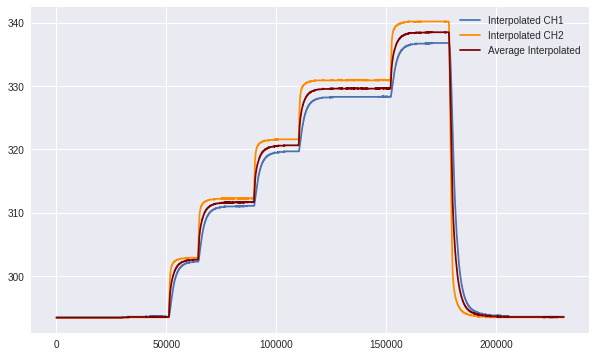

In [44]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(CO2_final_data['Exp_Time'], CO2_final_data['ch1_lerp'], label='Interpolated CH1')
ax.plot(CO2_final_data['Exp_Time'], CO2_final_data['ch2_lerp'], label='Interpolated CH2', color='darkorange')
ax.plot(CO2_final_data['Exp_Time'], CO2_final_data['temp_est'], label='Average Interpolated', color='maroon')
ax.legend()

plt.show()

In [45]:
#IO.RemoveZipDir()